In [ ]:
# !wget https://object.pouta.csc.fi/Tatoeba-Challenge-v2021-08-07/eng-swa.tar
# !tar -xvf eng-swa.tar
# !pip install datasets
# from datasets import load_dataset

# swa_dataset = load_dataset("swahili_news")
# eng_dataset=load_dataset("english_news")
# for i in range(5):
#   print(dataset["train"]["text"][i])


In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
# separate translation pairs from a CSV file into two separate files with the translation sentence pairs
import csv

# Input CSV file and output file paths
input_csv_file = '../Downloads/datasets/enswdataset.csv'
output_english_file = '../Downloads/datasets/eng.txt'
output_swahili_file = '../Downloads/datasets/swa.txt'

# Open the CSV file for reading with the correct encoding
with open(input_csv_file, 'r', newline='', encoding='utf-8') as csv_file:
    reader = csv.reader(csv_file)

    # Open the output files for writing with UTF-8 encoding
    with open(output_english_file, 'w', encoding='utf-8') as english_output_file, open(output_swahili_file, 'w', encoding='utf-8') as swahili_output_file:
        for row in reader:
            if len(row) >= 2:
                english_sentence = row[0]
                swahili_sentence = row[1]

                # Write the sentences to the respective output files
                english_output_file.write(english_sentence + '\n')
                swahili_output_file.write(swahili_sentence + '\n')

# Close the output files
english_output_file.close()
swahili_output_file.close()

print("Translation pairs separated and saved to files.")

Translation pairs separated and saved to files.


In [3]:
import re
import random
data_path = "../Downloads/datasets/eng.txt"
data_path2 = "../Downloads/datasets/swa.txt"
# Defining lines as a list of each line
with open(data_path, 'r', encoding='utf-8') as f:
  lines = f.read().strip().split('\n')
with open(data_path2, 'r', encoding='utf-8') as f:
  lines2 = f.read().strip().split('\n')

lines = [" ".join(re.findall(r"[A-Za-z0-9]+",line)) for line in lines]
lines2 = [" ".join(re.findall(r"[A-Za-z0-9]+",line)) for line in lines2]

In [4]:
# Grouping lines by response pair
pairs = list(zip(lines,lines2))
# pairs = pairs[:3000]
random.shuffle(pairs)
print(len(pairs))

8538


In [5]:
print(pairs[6473])

('He worked as a Software Engineer for five years', 'Alifanya kazi kama mhandisi wa programu kwa miaka mitano')


# printing random pairs


In [6]:
import random
print(random.choice(pairs))

('Her party dress was red in colour', 'Mavazi yake ya sherehe yalikuwa nyekundu kwa rangi')


In [7]:
import random
random.shuffle(pairs)
num_val_samples = int(0.15 * len(pairs))
num_train_samples = len(pairs) - 2 * num_val_samples
train_pairs = pairs[:num_train_samples]
val_pairs = pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs =pairs[num_train_samples + num_val_samples:]


# Vectorizing the English and Swahili text pairs


In [8]:

import tensorflow as tf
import string
import re
from tensorflow import keras
from tensorflow.keras import layers

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 15000
sequence_length = 20

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_swahili_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_swahili_texts)


2023-12-11 10:42:57.438340: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 10:42:57.438455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 10:42:57.561836: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 10:42:57.825501: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 10:43:04.101095: W tensorflow/compiler/tf2

# Preparing datasets for the translation task


In [9]:

batch_size = 512

def format_dataset(eng, swa):
    eng = source_vectorization(eng)
    swa = target_vectorization(swa)
    return ({
        "english": eng,
        "swahili": swa[:, :-1],
    }, swa[:, 1:])

def make_dataset(pairs):
    eng_texts, swa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    swa_texts = list(swa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, swa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [10]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['swahili'].shape: {inputs['swahili'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (346, 20)
inputs['swahili'].shape: (346, 20)
targets.shape: (346, 20)


2023-12-11 10:43:09.423352: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Sequence-to-sequence learning with RNNs
 GRU-based encoder

In [11]:
# Sequence-to-sequence learning with RNNs
# GRU-based encoder

from tensorflow import keras
from tensorflow.keras import layers

embed_dim = 256
latent_dim = 1024

source = keras.Input(shape=(None,), dtype="int64", name="english")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)
encoded_source = layers.Bidirectional(
    layers.GRU(latent_dim), merge_mode="sum")(x)

# GRU-based decoder and the end-to-end model


In [12]:

past_target = keras.Input(shape=(None,), dtype="int64", name="swahili")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)
decoder_gru = layers.GRU(latent_dim, return_sequences=True)
x = decoder_gru(x, initial_state=encoded_source)
x = layers.Dropout(0.5)(x)
target_next_step = layers.Dense(vocab_size, activation="softmax")(x)
seq2seq_rnn = keras.Model([source, past_target], target_next_step)

# Training our recurrent sequence-to-sequence model


In [ ]:

seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
# seq2seq_rnn.fit(train_ds, epochs=15, validation_data=val_ds)
history=seq2seq_rnn.fit(train_ds, epochs=50, validation_data=val_ds)


Epoch 1/50
314/314 [==============================] - 151s 417ms/step - loss: 6.2536 - accuracy: 0.1856 - val_loss: 5.7300 - val_accuracy: 0.2081
Epoch 2/50
314/314 [==============================] - 125s 398ms/step - loss: 5.6503 - accuracy: 0.2151 - val_loss: 5.3780 - val_accuracy: 0.2392
Epoch 3/50
314/314 [==============================] - 126s 402ms/step - loss: 5.3383 - accuracy: 0.2400 - val_loss: 5.1057 - val_accuracy: 0.2596
Epoch 4/50
314/314 [==============================] - 127s 404ms/step - loss: 5.0646 - accuracy: 0.2620 - val_loss: 4.8463 - val_accuracy: 0.2799
Epoch 5/50
314/314 [==============================] - 127s 404ms/step - loss: 4.8151 - accuracy: 0.2837 - val_loss: 4.6055 - val_accuracy: 0.3044
Epoch 6/50
314/314 [==============================] - 127s 404ms/step - loss: 4.5946 - accuracy: 0.3036 - val_loss: 4.4239 - val_accuracy: 0.3212
Epoch 7/50
314/314 [==============================] - 127s 404ms/step - loss: 4.3889 - accuracy: 0.3228 - val_loss: 4.2362 -

# Translating new sentences with our RNN encoder and decoder


In [ ]:

import numpy as np
swa_vocab = target_vectorization.get_vocabulary()
swa_index_lookup = dict(zip(range(len(swa_vocab)), swa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        next_token_predictions = seq2seq_rnn.predict(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = swa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
That s a horse of a different color
1/1 [==============================] - 0s 92ms/step
[start] ni farasi wa rangi tofauti  [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]
-
Terms related to vienna convention on diplomatic relations
1/1 [==============================] - 0s 36ms/step
[start] yanayohusiana na makubaliano ya vienna kwa uhusiano wa kidiplomasia  [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]
-
What are some benefits that children derive from a wholesome family atmosphere
1/1 [==============================] - 0s 92ms/step
[start] ni watu gani muhimu [UNK] [UNK] katika familia ya afya  [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]
-
It s very easy to sound natural in your own native language and very easy to sound unnatural in your non native language
1/1 [==============================] - 0s 96ms/step
[start] sana ni ngumu kusikika katika lugha yako ya asili na yenye nguvu kabisa kama vile [UNK] katika asili ni lu

### "[UNK]" stands for "unknown" tokens.
- These tokens represent words or characters in the generated translation that the model couldn't confidently predict or understand during the translation process.


- There are various reasons why the model might produce "[UNK]" tokens. It could be encountering words or phrases that are rare or not present in its training data. Alternatively, it may be struggling with out-of-vocabulary words or misspelled words that were not part of its training set.


Visualization of accuracy and validation

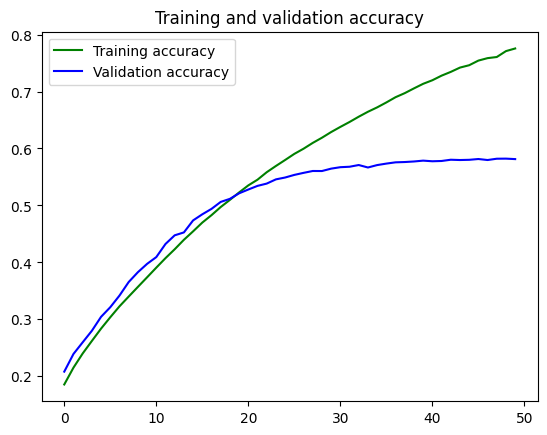

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

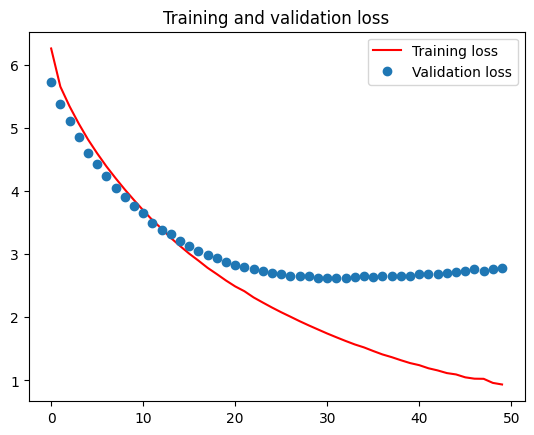

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.savefig('wordA.png')
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'o', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.savefig('wordL.png')
plt.figure()

# **# Sequence-to-sequence learning with Transformer**

*The TransformerDecoder*
 *The Transformer decoder*

In [13]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self,inputs,mask=None):
      if mask is not None:
        mask=mask[:, tf.newaxis,:]
      attention_output=self.attention(
          inputs,attention_mask=mask
      )
      proj_input=self.layernorm_1(inputs + attention_output)
      proj_output=self.dense_proj(proj_input)
      return self.layernorm_2(proj_input+proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        else:
            padding_mask = mask
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)


# PositionalEmbedding layer



In [14]:

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [15]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable


In [16]:
import tensorflow as tf

class MyTransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(MyTransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense1 = tf.keras.layers.Dense(dense_dim, activation="relu")
        self.dense2 = tf.keras.layers.Dense(embed_dim)
        self.dropout1 = tf.keras.layers.Dropout(0.1)
        self.dropout2 = tf.keras.layers.Dropout(0.1)
        self.layer_norm1 = tf.keras.layers.LayerNormalization()
        self.layer_norm2 = tf.keras.layers.LayerNormalization()

    def call(self, inputs, training=False):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layer_norm1(inputs + attn_output)
        dense_output = self.dense1(out1)
        dense_output = self.dense2(dense_output)
        dense_output = self.dropout2(dense_output, training=training)
        out2 = self.layer_norm2(out1 + dense_output)
        return out2


In [17]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = MyTransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="swahili")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [18]:
transformer.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 english (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 swahili (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 positional_embedding (Posi  (None, None, 256)            3845120   ['english[0][0]']             
 tionalEmbedding)                                                                                 
                                                                                                  
 positional_embedding_1 (Po  (None, None, 256)            3845120   ['swahili[0][0]']       

# Training the sequence-to-sequence Transformer





In [19]:

transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
history=transformer.fit(train_ds, epochs=50, validation_data=val_ds)


Epoch 1/50


2023-12-11 10:43:54.506717: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 415200000 exceeds 10% of free system memory.
2023-12-11 10:43:55.479855: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 415200000 exceeds 10% of free system memory.
2023-12-11 10:43:55.480021: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 415200000 exceeds 10% of free system memory.


 1/12 [=>............................] - ETA: 3:02 - loss: 9.6444 - accuracy: 0.0000e+00

2023-12-11 10:44:04.930951: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.
2023-12-11 10:44:05.880656: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.


12/12 [==============================] - 193s 16s/step - loss: 7.9741 - accuracy: 0.1282 - val_loss: 6.8449 - val_accuracy: 0.1378
Epoch 2/50
12/12 [==============================] - 154s 13s/step - loss: 6.6423 - accuracy: 0.1383 - val_loss: 6.5139 - val_accuracy: 0.1412
Epoch 3/50
12/12 [==============================] - 157s 14s/step - loss: 6.4572 - accuracy: 0.1428 - val_loss: 6.3882 - val_accuracy: 0.1472
Epoch 4/50
12/12 [==============================] - 141s 12s/step - loss: 6.2922 - accuracy: 0.1532 - val_loss: 6.2324 - val_accuracy: 0.1637
Epoch 5/50
12/12 [==============================] - 138s 12s/step - loss: 6.1263 - accuracy: 0.1663 - val_loss: 6.1332 - val_accuracy: 0.1853
Epoch 6/50
12/12 [==============================] - 138s 12s/step - loss: 5.9011 - accuracy: 0.1886 - val_loss: 5.9463 - val_accuracy: 0.2094
Epoch 7/50
12/12 [==============================] - 141s 12s/step - loss: 5.7947 - accuracy: 0.2012 - val_loss: 5.8229 - val_accuracy: 0.2163
Epoch 8/50
12/12 

**visualization of accuracy and validation**

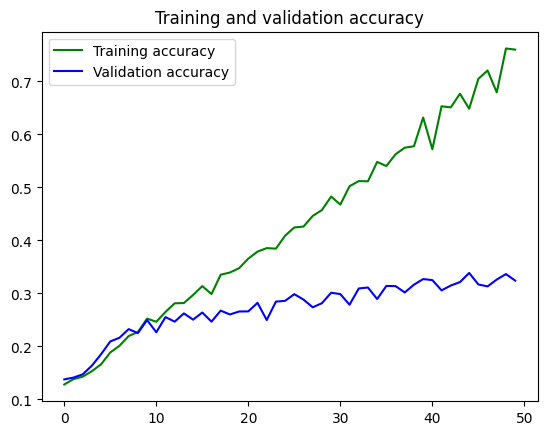

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

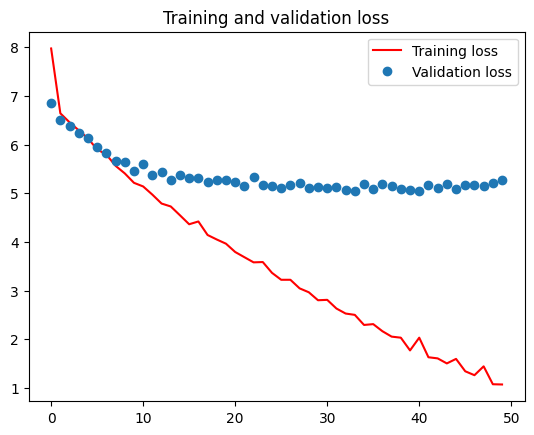

<Figure size 640x480 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.savefig('wordA2.png')
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'o', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.savefig('wordL2.png')
plt.figure()

# Translating new sentences with our Transformer model






In [21]:


import numpy as np
swa_vocab = target_vectorization.get_vocabulary()
swa_index_lookup = dict(zip(range(len(swa_vocab)), swa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = swa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)

    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))


-
The regime was responsible for the death of civilians across the country
[start] huyo aliripoti juu ya kesi ya umeme             
-
Patients who fail to swallow medicine as prescribed take long to recover
[start] chakula cha mama yangu baada ya mtu mwingine            leo
-
One of the presidential candidates is popular
[start] moja ya nyumba ni uchaguzi               
-
The soldiers had just completed their training
[start] huyo aliripoti juu ya kifo cha polisi             
-
His short videos made rounds on the social platforms
[start] yake ndogo iko kwenye shamba lake              leo
-
The dogs were barking out loud at night
[start] hiyo sio nyumba zao                leo
-
Many people fled into rural areas
[start] wengi walipoteza maisha ya vijijini               
-
The kids feel safe when their father is around
[start] hiyo ni wakati baba yao yuko karibu             leo
-
Poultry is encouraged to enable people earn money
[start] watu hawa wanafanya nini                leo
-
There 